In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LSTM, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
sns.set()
np.random.seed(10)

In [2]:
spam_df = pd.read_csv('spam.csv',encoding='ISO-8859-1')
spam_df.head(2)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN


In [3]:
spam_df = spam_df[['v1','v2']].copy()
spam_df.columns = ['spam','text']
spam_df['spam'] = spam_df['spam'].map({'ham':0,'spam':1})
spam_df.sample(2)

,spam,text
4635,0,K k pa Had your lunch aha.
2279,0,"Sorry, I'll call later in meeting"


In [4]:
spam_df.shape

(5572, 2)

In [5]:
spam_df['spam'].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: spam, dtype: float64

In [6]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(spam_df['text'], spam_df['spam'],
                                                    test_size=0.20, stratify=spam_df['spam'])

In [7]:
# convert sentences to sequence
max_vocab_size = 10000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x_train)
seq_train = tokenizer.texts_to_sequences(x_train)
seq_test = tokenizer.texts_to_sequences(x_test)

In [8]:
# num of vocab
len(tokenizer.word_index)

7895

In [9]:
# pad sequences for equal length
input_train = pad_sequences(seq_train)
input_train.shape

(4457, 189)

In [10]:
max_length = input_train.shape[1]
input_test = pad_sequences(seq_test,maxlen=max_length)
input_test.shape

(1115, 189)

In [11]:
# output size for embedding layer
out_dim = 10

# input size for embedding layer
input_dim = len(tokenizer.word_index) + 1 # 1 for 0th index 

# Create LSTM Model
i = Input(shape=(max_length,))

# embedding layer
x = Embedding(input_dim,out_dim)(i)

# LSTM Layer
x = LSTM(10,return_sequences=True)(x)

# Global max pooling
x = GlobalMaxPooling1D()(x)

# output layer
x = Dense(1,activation='sigmoid')(x)

# Model
model = Model(i,x)

In [12]:
# Compile
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','AUC'])

In [13]:
# training
hist = model.fit(input_train,y_train.values,epochs=10,validation_data=(input_test,y_test.values))

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 21s 5ms/sample - loss: 0.4933 - accuracy: 0.8600 - AUC: 0.5771 - val_loss: 0.3409 - val_accuracy: 0.8664 - val_AUC: 0.9441
Epoch 2/10
4457/4457 [==============================] - 18s 4ms/sample - loss: 0.3091 - accuracy: 0.8658 - AUC: 0.9589 - val_loss: 0.2895 - val_accuracy: 0.8664 - val_AUC: 0.9730
Epoch 3/10
4457/4457 [==============================] - 21s 5ms/sample - loss: 0.2690 - accuracy: 0.8658 - AUC: 0.9809 - val_loss: 0.2522 - val_accuracy: 0.8664 - val_AUC: 0.9819
Epoch 4/10
4457/4457 [==============================] - 18s 4ms/sample - loss: 0.2294 - accuracy: 0.8658 - AUC: 0.9838 - val_loss: 0.2122 - val_accuracy: 0.8664 - val_AUC: 0.9822
Epoch 5/10
4457/4457 [==============================] - 18s 4ms/sample - loss: 0.1899 - accuracy: 0.8658 - AUC: 0.9895 - val_loss: 0.1808 - val_accuracy: 0.8664 - val_AUC: 0.9822
Epoch 6/10
4457/4457 [==============================] - 1

In [14]:
# Check accuracy on test dataset
predict = model.predict(input_test).round().astype(int)
print('Test Accuracy {}'.format(accuracy_score(y_test,predict)))
print('Test F1 Score {}'.format(f1_score(y_test,predict))) 

Test Accuracy 0.9910313901345291
Test F1 Score 0.9652777777777778


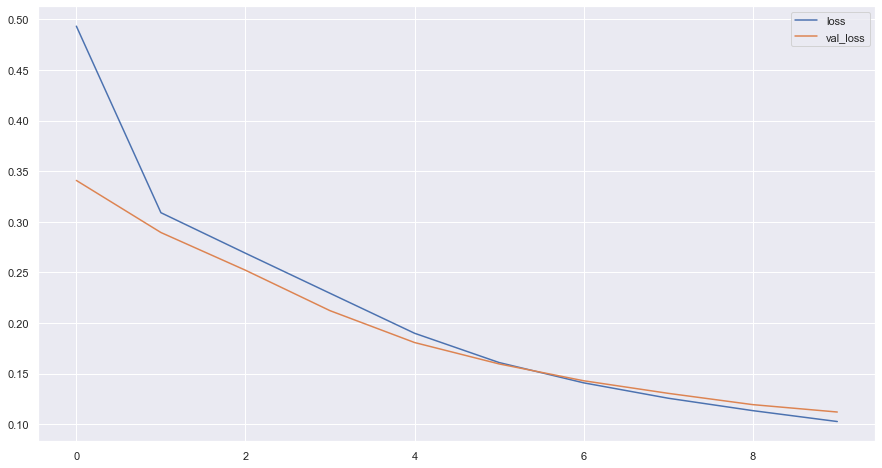

In [15]:
# plot loss 
plt.figure(figsize=(15,8))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

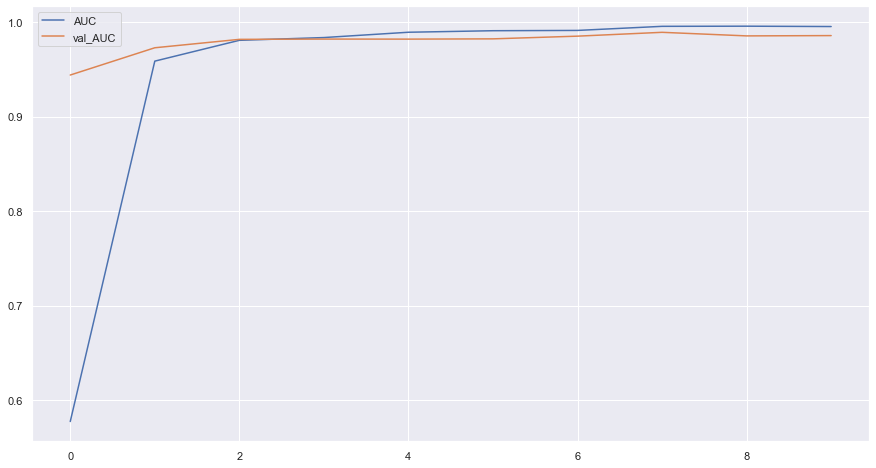

In [16]:
# plot AUC
plt.figure(figsize=(15,8))
plt.plot(hist.history['AUC'], label='AUC')
plt.plot(hist.history['val_AUC'], label='val_AUC')
plt.legend()